In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

In [2]:
from torch.utils.data import Dataset
import torch
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("PyTorch version:", torch.__version__)
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

class BeamDatasetGAN(Dataset):
    """
    Dataset for GAN training - includes conditional information
    Conditions: [x_center, y_center, sigma_x, sigma_y]
    """
    
    def __init__(self, csv_file, image_dir, normalize_conditions=True):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
            normalize_conditions (bool): Whether to normalize condition values
        """
        self.data_frame = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.normalize_conditions = normalize_conditions
        
        # Calculate normalization parameters for conditions
        if normalize_conditions:
            self.condition_means = self.data_frame[['x_center', 'y_center', 'sigma_x', 'sigma_y']].mean().values.astype(np.float32)
            self.condition_stds = self.data_frame[['x_center', 'y_center', 'sigma_x', 'sigma_y']].std().values.astype(np.float32)
        
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_name = os.path.join(self.image_dir, self.data_frame.iloc[idx]['filename'])
        image = Image.open(img_name).convert('L')  # Convert to grayscale
        image = np.array(image, dtype=np.float32)
        
        # Normalize image to [-1, 1] for GAN training (standard practice)
        image = (image / 255.0) * 2.0 - 1.0
        
        # Add channel dimension: (1, 32, 32)
        image = image[np.newaxis, :, :]
        
        # Get conditional information
        row = self.data_frame.iloc[idx]
        conditions = np.array([
            row['x_center'],
            row['y_center'], 
            row['sigma_x'],
            row['sigma_y']
        ], dtype=np.float32)
        
        # Normalize conditions if requested
        if self.normalize_conditions:
            conditions = ((conditions - self.condition_means) / self.condition_stds).astype(np.float32)
        
        # Convert to tensors
        image = torch.from_numpy(image)
        conditions = torch.from_numpy(conditions)
        
        return image, conditions

def load_gan_dataset(data_dir="beam_dataset", test_size=0.2, random_state=42):
    """
    Load dataset for GAN training
    """
    # Paths
    csv_path = os.path.join(data_dir, "beam_data.csv")
    image_dir = os.path.join(data_dir, "images")
    
    # Check if train/val splits exist
    train_csv = os.path.join(data_dir, "train_data.csv")
    val_csv = os.path.join(data_dir, "val_data.csv")
    
    
    # Create datasets
    train_dataset = BeamDatasetGAN(train_csv, image_dir)
    val_dataset = BeamDatasetGAN(val_csv, image_dir)
    
    print(f"GAN training set size: {len(train_dataset)}")
    print(f"GAN validation set size: {len(val_dataset)}")
    print(f"Image shape: {train_dataset[0][0].shape}")  # Should be (1, 32, 32)
    print(f"Condition shape: {train_dataset[0][1].shape}")  # Should be (4,)
    print(f"Image range: [{train_dataset[0][0].min():.2f}, {train_dataset[0][0].max():.2f}]")
    
    return train_dataset, val_dataset

PyTorch version: 2.3.0.dev20240118
Device: cpu


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

def plot_training_history(history):
    """Plot training and validation loss curves"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    ax1.plot(history['train_loss'], label='Training Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # MSE curves (same as loss for regression)
    ax2.plot(history['train_mse'], label='Training MSE', color='blue')
    ax2.plot(history['val_mse'], label='Validation MSE', color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Squared Error')
    ax2.set_title('Training and Validation MSE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_predictions(evaluation_results, num_samples=8):
    """
    Visualize model predictions vs ground truth
    
    Args:
        evaluation_results: Results from evaluate_model function
        num_samples: Number of samples to visualize
    """
    predictions = evaluation_results['predictions']
    targets = evaluation_results['targets']
    
    # Select random samples
    indices = np.random.choice(len(predictions), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        pred_x, pred_y = predictions[idx]
        true_x, true_y = targets[idx]
        
        # Create a visualization of the prediction
        ax = axes[i]
        
        # Plot as scatter plot showing prediction vs ground truth
        ax.scatter(true_x, true_y, c='red', s=100, marker='x', label='Ground Truth', linewidth=3)
        ax.scatter(pred_x, pred_y, c='blue', s=100, marker='o', label='Prediction', alpha=0.7)
        
        # Draw line between prediction and ground truth
        ax.plot([true_x, pred_x], [true_y, pred_y], 'k--', alpha=0.5)
        
        # Calculate error
        error = np.sqrt((pred_x - true_x)**2 + (pred_y - true_y)**2)
        
        ax.set_xlim(0, 32)
        ax.set_ylim(0, 32)
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title(f'Sample {idx}\nError: {error:.2f} pixels')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Model Predictions vs Ground Truth', fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_error_distribution(evaluation_results):
    """Plot distribution of prediction errors"""
    
    predictions = evaluation_results['predictions']
    targets = evaluation_results['targets']
    
    # Calculate errors
    errors_x = predictions[:, 0] - targets[:, 0]
    errors_y = predictions[:, 1] - targets[:, 1]
    errors_total = np.sqrt(errors_x**2 + errors_y**2)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # X-axis error distribution
    axes[0, 0].hist(errors_x, bins=30, alpha=0.7, color='blue')
    axes[0, 0].set_xlabel('X Prediction Error (pixels)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('X-axis Error Distribution')
    axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.8)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Y-axis error distribution
    axes[0, 1].hist(errors_y, bins=30, alpha=0.7, color='green')
    axes[0, 1].set_xlabel('Y Prediction Error (pixels)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Y-axis Error Distribution')
    axes[0, 1].axvline(0, color='red', linestyle='--', alpha=0.8)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Total error distribution
    axes[1, 0].hist(errors_total, bins=30, alpha=0.7, color='purple')
    axes[1, 0].set_xlabel('Total Prediction Error (pixels)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Total Error Distribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Scatter plot: predicted vs actual
    axes[1, 1].scatter(targets[:, 0], predictions[:, 0], alpha=0.5, label='X-axis')
    axes[1, 1].scatter(targets[:, 1], predictions[:, 1], alpha=0.5, label='Y-axis')
    axes[1, 1].plot([0, 32], [0, 32], 'r--', alpha=0.8, label='Perfect Prediction')
    axes[1, 1].set_xlabel('True Position')
    axes[1, 1].set_ylabel('Predicted Position')
    axes[1, 1].set_title('Predicted vs True Positions')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def visualize_cnn_filters(model, save_path=None):
    """
    Visualize the learned convolutional filters
    
    Args:
        model: Trained CNN model
        save_path: Optional path to save the figure
    """
    
    # Get first convolutional layer
    first_conv = None
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            first_conv = module
            break
    
    if first_conv is None:
        print("No convolutional layer found!")
        return
    
    # Get weights and convert to numpy
    filters = first_conv.weight.data.cpu().numpy()
    
    # Number of filters to display
    num_filters = min(16, filters.shape[0])
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(num_filters):
        # Get filter (remove channel dimension if input is grayscale)
        filter_img = filters[i, 0, :, :]  # Shape: (kernel_size, kernel_size)
        
        axes[i].imshow(filter_img, cmap='RdBu', vmin=-filter_img.max(), vmax=filter_img.max())
        axes[i].set_title(f'Filter {i+1}')
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(num_filters, 16):
        axes[i].axis('off')
    
    plt.suptitle('Learned Convolutional Filters (First Layer)', fontsize=16)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def visualize_feature_maps(model, sample_image, save_path=None):
    """
    Visualize feature maps from convolutional layers
    
    Args:
        model: Trained CNN model
        sample_image: Input image tensor (1, 1, 32, 32)
        save_path: Optional path to save the figure
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    # Hook to capture intermediate outputs
    feature_maps = []
    
    def hook_fn(module, input, output):
        feature_maps.append(output.cpu().detach())
    
    # Register hooks for conv layers
    hooks = []
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            hooks.append(module.register_forward_hook(hook_fn))
            conv_layers.append(name)
    
    # Forward pass
    sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        _ = model(sample_image)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Visualize feature maps from first conv layer
    if feature_maps:
        feature_map = feature_maps[0][0]  # First sample, first layer
        num_features = min(16, feature_map.shape[0])
        
        fig, axes = plt.subplots(4, 4, figsize=(12, 12))
        axes = axes.flatten()
        
        for i in range(num_features):
            feature = feature_map[i].numpy()
            axes[i].imshow(feature, cmap='hot')
            axes[i].set_title(f'Feature Map {i+1}')
            axes[i].axis('off')
        
        # Hide unused subplots
        for i in range(num_features, 16):
            axes[i].axis('off')
        
        plt.suptitle('Feature Maps from First Convolutional Layer', fontsize=16)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

def plot_gan_training(history):
    """Plot GAN training curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss curves
    axes[0, 0].plot(history['g_loss'], label='Generator Loss', color='blue')
    axes[0, 0].plot(history['d_loss'], label='Discriminator Loss', color='red')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Generator vs Discriminator Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Discriminator accuracy
    axes[0, 1].plot(history['d_real_acc'], label='Real Accuracy', color='green')
    axes[0, 1].plot(history['d_fake_acc'], label='Fake Accuracy', color='orange')
    axes[0, 1].axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Random Guess')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Discriminator Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Training balance analysis
    g_loss_smooth = np.convolve(history['g_loss'], np.ones(10)/10, mode='valid')
    d_loss_smooth = np.convolve(history['d_loss'], np.ones(10)/10, mode='valid')
    
    axes[1, 0].plot(g_loss_smooth, label='Generator (smoothed)', color='blue')
    axes[1, 0].plot(d_loss_smooth, label='Discriminator (smoothed)', color='red')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss (Smoothed)')
    axes[1, 0].set_title('Training Balance (Smoothed)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Loss ratio
    loss_ratio = np.array(history['g_loss']) / (np.array(history['d_loss']) + 1e-8)
    axes[1, 1].plot(loss_ratio, color='purple')
    axes[1, 1].axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Balanced')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('G_Loss / D_Loss')
    axes[1, 1].set_title('Training Balance Ratio')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualize_generated_beams_gan(generated_images, conditions, title="Generated Beams (GAN)"):
    """
    Visualize generated beam images with their conditions
    """
    num_images = min(8, generated_images.shape[0])
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(num_images):
        img = generated_images[i, 0].cpu().numpy()
        cond = conditions[i].cpu().numpy() if torch.is_tensor(conditions) else conditions[i]
        
        axes[i].imshow(img, cmap='hot', origin='lower')
        axes[i].set_title(f'Condition {i+1}\n({cond[0]:.2f}, {cond[1]:.2f}, {cond[2]:.2f}, {cond[3]:.2f})')
        axes[i].set_xlabel('X pixel')
        axes[i].set_ylabel('Y pixel')
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def compare_real_vs_generated_gan(real_images, real_conditions, generated_images, generated_conditions):
    """
    Compare real vs generated images side by side
    """
    num_samples = min(4, real_images.shape[0])
    
    fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))
    
    for i in range(num_samples):
        # Real images (top row)
        real_img = real_images[i, 0].cpu().numpy()
        # Convert from [-1, 1] to [0, 1] if needed
        if real_img.min() < 0:
            real_img = (real_img + 1.0) / 2.0
        
        real_cond = real_conditions[i].cpu().numpy() if torch.is_tensor(real_conditions) else real_conditions[i]
        
        axes[0, i].imshow(real_img, cmap='hot', origin='lower')
        axes[0, i].set_title(f'Real Beam {i+1}\n({real_cond[0]:.2f}, {real_cond[1]:.2f}, {real_cond[2]:.2f}, {real_cond[3]:.2f})')
        axes[0, i].set_xlabel('X pixel')
        axes[0, i].set_ylabel('Y pixel')
        
        # Generated images (bottom row)  
        gen_img = generated_images[i, 0].cpu().numpy()
        gen_cond = generated_conditions[i].cpu().numpy() if torch.is_tensor(generated_conditions) else generated_conditions[i]
        
        axes[1, i].imshow(gen_img, cmap='hot', origin='lower')
        axes[1, i].set_title(f'Generated Beam {i+1}\n({gen_cond[0]:.2f}, {gen_cond[1]:.2f}, {gen_cond[2]:.2f}, {gen_cond[3]:.2f})')
        axes[1, i].set_xlabel('X pixel')
        axes[1, i].set_ylabel('Y pixel')
    
    plt.suptitle('Real vs Generated Beam Comparison (GAN)', fontsize=16)
    plt.tight_layout()
    plt.show()


In [4]:

class ConditionalGenerator(nn.Module):
    """
    Generator network that creates beam images from noise + conditions
    
    Takes:
    - Random noise vector (latent_dim)  
    - Condition vector (4D: x, y, sigma_x, sigma_y)
    
    Outputs:
    - Generated beam image (1, 32, 32)
    """
    
    def __init__(self, latent_dim=100, condition_dim=4, base_channels=64):
        super(ConditionalGenerator, self).__init__()
        
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        
        # Condition embedding
        self.condition_embedding = nn.Sequential(
            nn.Linear(condition_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        
        # Combined input size (noise + embedded conditions)
        input_dim = latent_dim + 64
        
        # Generator architecture: FC layers -> Reshape -> Conv layers
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, base_channels * 8 * 4 * 4),  # 4x4 feature maps
            nn.BatchNorm1d(base_channels * 8 * 4 * 4),
            nn.ReLU(inplace=True)
        )
        
        # Convolutional layers for upsampling 4x4 -> 8x8 -> 16x16 -> 32x32
        self.conv_layers = nn.Sequential(
            # 4x4 -> 8x8
            nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            
            # 8x8 -> 16x16  
            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
            
            # 16x16 -> 32x32
            nn.ConvTranspose2d(base_channels * 2, base_channels, 4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            
            # Final layer: 32x32 -> 32x32, 1 channel output
            nn.Conv2d(base_channels, 1, 3, padding=1),
            nn.Tanh()  # Output in [-1, 1] range
        )
        
        self.base_channels = base_channels
        
    def forward(self, noise, conditions):
        """
        Args:
            noise: Random noise (batch_size, latent_dim)
            conditions: Condition vectors (batch_size, 4)
        """
        batch_size = noise.shape[0]
        
        # Embed conditions
        cond_emb = self.condition_embedding(conditions.float())  # (batch_size, 64)
        
        # Concatenate noise and conditions
        x = torch.cat([noise, cond_emb], dim=1)  # (batch_size, latent_dim + 64)
        
        # Fully connected layers
        x = self.fc_layers(x)  # (batch_size, base_channels * 8 * 4 * 4)
        
        # Reshape for convolution
        x = x.view(batch_size, self.base_channels * 8, 4, 4)  # (batch_size, channels, 4, 4)
        
        # Convolutional upsampling
        x = self.conv_layers(x)  # (batch_size, 1, 32, 32)
        
        return x

class ConditionalDiscriminator(nn.Module):
    """
    Discriminator network that distinguishes real from fake images
    Also takes conditions as input for conditional generation
    
    Takes:
    - Image (1, 32, 32)
    - Condition vector (4D: x, y, sigma_x, sigma_y)
    
    Outputs:
    - Probability that image is real (scalar)
    """
    
    def __init__(self, condition_dim=4, base_channels=64):
        super(ConditionalDiscriminator, self).__init__()
        
        # Condition embedding
        self.condition_embedding = nn.Sequential(
            nn.Linear(condition_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32 * 32),  # Same size as flattened image
            nn.ReLU()
        )
        
        # Convolutional layers for image processing 32x32 -> 16x16 -> 8x8 -> 4x4
        self.conv_layers = nn.Sequential(
            # 32x32 -> 16x16 (input: 1 + 1 = 2 channels, image + embedded condition)
            nn.Conv2d(2, base_channels, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            
            # 16x16 -> 8x8
            nn.Conv2d(base_channels, base_channels * 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            
            # 8x8 -> 4x4
            nn.Conv2d(base_channels * 2, base_channels * 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            
            # 4x4 -> 2x2
            nn.Conv2d(base_channels * 4, base_channels * 8, 4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Final classification layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(base_channels * 8 * 2 * 2, 1),
            nn.Sigmoid()  # Output probability [0, 1]
        )
        
    def forward(self, image, conditions):
        """
        Args:
            image: Images (batch_size, 1, 32, 32)
            conditions: Condition vectors (batch_size, 4)
        """
        batch_size = image.shape[0]
        
        # Embed conditions and reshape to match image dimensions
        cond_emb = self.condition_embedding(conditions.float())  # (batch_size, 32*32)
        cond_emb = cond_emb.view(batch_size, 1, 32, 32)  # (batch_size, 1, 32, 32)
        
        # Concatenate image and condition along channel dimension
        x = torch.cat([image, cond_emb], dim=1)  # (batch_size, 2, 32, 32)
        
        # Convolutional processing
        x = self.conv_layers(x)
        
        # Final classification
        output = self.classifier(x)
        
        return output.squeeze()  # Remove extra dimensions

In [5]:
def train_gan(generator, discriminator, train_loader, val_loader, num_epochs=200, 
              lr_g=0.0002, lr_d=0.0002, latent_dim=100):
    """
    Train the conditional GAN
    
    Args:
        generator: Generator network
        discriminator: Discriminator network
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of training epochs
        lr_g: Learning rate for generator
        lr_d: Learning rate for discriminator
        latent_dim: Dimension of noise vector
    
    Returns:
        Dictionary with training history
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)
    
    # Optimizers
    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    
    # Loss function
    criterion = nn.BCELoss()
    
    # Training history
    history = {
        'g_loss': [],
        'd_loss': [],
        'd_real_acc': [],
        'd_fake_acc': []
    }
    
    # Labels
    real_label = 0.9  # Label smoothing: use 0.9 instead of 1.0
    fake_label = 0.0
    
    print("Starting GAN training...")
    print("-" * 50)
    
    for epoch in range(num_epochs):
        g_losses = []
        d_losses = []
        d_real_accs = []
        d_fake_accs = []
        
        for batch_idx, (real_images, real_conditions) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images, real_conditions = real_images.to(device), real_conditions.to(device)
            
            # =============================================================================
            # Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
            # =============================================================================
            
            discriminator.zero_grad()
            
            # Train with real images
            real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            real_output = discriminator(real_images, real_conditions)
            d_loss_real = criterion(real_output, real_labels)
            d_loss_real.backward()
            
            # Calculate accuracy on real images
            d_real_acc = ((real_output > 0.5).float().mean().item())
            
            # Train with fake images
            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_images = generator(noise, real_conditions)
            fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
            fake_output = discriminator(fake_images.detach(), real_conditions)
            d_loss_fake = criterion(fake_output, fake_labels)
            d_loss_fake.backward()
            
            # Calculate accuracy on fake images
            d_fake_acc = ((fake_output < 0.5).float().mean().item())
            
            d_loss = d_loss_real + d_loss_fake
            optimizer_d.step()
            
            # =============================================================================
            # Train Generator: maximize log(D(G(z)))
            # =============================================================================
            
            generator.zero_grad()
            
            # Generator wants discriminator to classify fake images as real
            fake_output = discriminator(fake_images, real_conditions)
            real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            g_loss = criterion(fake_output, real_labels)
            g_loss.backward()
            optimizer_g.step()
            
            # Store losses
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())
            d_real_accs.append(d_real_acc)
            d_fake_accs.append(d_fake_acc)
        
        # Calculate epoch averages
        avg_g_loss = np.mean(g_losses)
        avg_d_loss = np.mean(d_losses)
        avg_d_real_acc = np.mean(d_real_accs)
        avg_d_fake_acc = np.mean(d_fake_accs)
        
        # Store history
        history['g_loss'].append(avg_g_loss)
        history['d_loss'].append(avg_d_loss)
        history['d_real_acc'].append(avg_d_real_acc)
        history['d_fake_acc'].append(avg_d_fake_acc)
        
        # Print progress
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"  G Loss:     {avg_g_loss:.4f}")
            print(f"  D Loss:     {avg_d_loss:.4f}")
            print(f"  D Real Acc: {avg_d_real_acc:.4f}")
            print(f"  D Fake Acc: {avg_d_fake_acc:.4f}")
            print("-" * 30)
    
    print("GAN training completed!")
    return history

In [6]:
@torch.no_grad()
def generate_images(generator, conditions, latent_dim=100, device=None):
    """
    Generate images using the trained generator
    
    Args:
        generator: Trained generator model
        conditions: Conditioning vectors (num_samples, 4)
        latent_dim: Dimension of noise vector
        device: Device to run on
    
    Returns:
        Generated images tensor
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    generator.eval()
    num_samples = conditions.shape[0]
    
    # Sample random noise
    noise = torch.randn(num_samples, latent_dim, device=device)
    conditions = conditions.to(device)
    
    # Generate images
    fake_images = generator(noise, conditions)
    
    # Convert from [-1, 1] to [0, 1]
    fake_images = (fake_images + 1.0) / 2.0
    fake_images = torch.clamp(fake_images, 0.0, 1.0)
    
    return fake_images

def create_custom_conditions_gan(x_centers, y_centers, sigma_xs, sigma_ys, 
                                train_dataset=None, normalize=True):
    """
    Create custom conditioning vectors for generation
    Same as diffusion version but for GAN
    """
    conditions = np.array([x_centers, y_centers, sigma_xs, sigma_ys]).T
    conditions = conditions.astype(np.float32)
    
    # Normalize if requested
    if normalize and train_dataset is not None:
        conditions = ((conditions - train_dataset.condition_means) / train_dataset.condition_stds).astype(np.float32)
    
    return torch.from_numpy(conditions)

def demonstrate_conditional_control_gan(generator, train_dataset, latent_dim=100):
    """
    Demonstrate conditional control by varying one parameter at a time
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Base condition (center of image, medium size beam)
    base_x, base_y = 16.0, 16.0  # Center of 32x32 image
    base_sigma_x, base_sigma_y = 2.5, 2.5  # Medium beam size
    
    # 1. Vary X position
    print("1. Varying X position (left to right)...")
    x_positions = [8, 12, 16, 20, 24]
    conditions = create_custom_conditions_gan(
        x_positions, [base_y]*5, [base_sigma_x]*5, [base_sigma_y]*5, 
        train_dataset
    )
    generated = generate_images(generator, conditions, latent_dim, device)
    visualize_generated_beams_gan(generated, conditions, "GAN: Varying X Position")
    
    # 2. Vary Y position  
    print("2. Varying Y position (bottom to top)...")
    y_positions = [8, 12, 16, 20, 24]
    conditions = create_custom_conditions_gan(
        [base_x]*5, y_positions, [base_sigma_x]*5, [base_sigma_y]*5,
        train_dataset
    )
    generated = generate_images(generator, conditions, latent_dim, device)
    visualize_generated_beams_gan(generated, conditions, "GAN: Varying Y Position")
    
    # 3. Vary beam size
    print("3. Varying beam size (small to large)...")
    beam_sizes = [1.5, 2.0, 2.5, 3.0, 3.5]
    conditions = create_custom_conditions_gan(
        [base_x]*5, [base_y]*5, beam_sizes, beam_sizes,
        train_dataset
    )
    generated = generate_images(generator, conditions, latent_dim, device)
    visualize_generated_beams_gan(generated, conditions, "GAN: Varying Beam Size")
    
    # 4. Create custom beam patterns
    print("4. Custom beam patterns...")
    custom_conditions = [
        [8, 8, 2.0, 2.0],    # Small beam, bottom-left
        [24, 24, 2.0, 2.0],  # Small beam, top-right  
        [16, 16, 4.0, 1.5],  # Wide beam, center
        [16, 16, 1.5, 4.0],  # Tall beam, center
    ]
    
    conditions = create_custom_conditions_gan(
        [c[0] for c in custom_conditions],
        [c[1] for c in custom_conditions], 
        [c[2] for c in custom_conditions],
        [c[3] for c in custom_conditions],
        train_dataset
    )
    generated = generate_images(generator, conditions, latent_dim, device)
    visualize_generated_beams_gan(generated, conditions, "GAN: Custom Beam Patterns")

In [7]:
def run_gan_experiment(latent_dim=100,
                      base_channels=64,
                      lr_g=0.0002,
                      lr_d=0.0002,
                      batch_size=32,
                      num_epochs=200):
    """
    Run complete GAN experiment with given hyperparameters
    
    Students can modify these parameters!
    """
    
    print("🔬 STARTING CONDITIONAL GAN EXPERIMENT")
    print("=" * 60)
    print(f"Hyperparameters:")
    print(f"  Latent dim: {latent_dim}")
    print(f"  Base channels: {base_channels}")
    print(f"  Generator LR: {lr_g}")
    print(f"  Discriminator LR: {lr_d}")
    print(f"  Batch size: {batch_size}")
    print(f"  Epochs: {num_epochs}")
    print("=" * 60)
    
    # 1. Load dataset
    train_dataset, val_dataset = load_gan_dataset()
    
    # 2. Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 3. Create models
    generator = ConditionalGenerator(
        latent_dim=latent_dim,
        condition_dim=4,
        base_channels=base_channels
    )
    discriminator = ConditionalDiscriminator(
        condition_dim=4,
        base_channels=base_channels
    )
    
    print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
    print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")
    
    # 4. Train models
    print(f"\n🏋️ Training GAN for {num_epochs} epochs...")
    history = train_gan(generator, discriminator, train_loader, val_loader, 
                       num_epochs, lr_g, lr_d, latent_dim)
    
    # 5. Plot training curves
    print(f"\n📈 Plotting training results...")
    plot_gan_training(history)
    
    # 6. Test generation with real conditions
    print(f"\n🎨 Testing generation with real conditions...")
    real_images, real_conditions = next(iter(val_loader))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Generate images with same conditions as real images
    generated_images = generate_images(generator, real_conditions[:4], latent_dim, device)
    
    # Compare real vs generated
    compare_real_vs_generated_gan(real_images[:4], real_conditions[:4], generated_images, real_conditions[:4])
    
    # 7. Demonstrate conditional control
    demonstrate_conditional_control_gan(generator, train_dataset, latent_dim)
    
    return {
        'generator': generator,
        'discriminator': discriminator,
        'history': history,
        'train_dataset': train_dataset
    }

🚀 Running GAN experiment...
🔬 STARTING CONDITIONAL GAN EXPERIMENT
Hyperparameters:
  Latent dim: 16
  Base channels: 8
  Generator LR: 0.0002
  Discriminator LR: 0.0002
  Batch size: 32
  Epochs: 50
GAN training set size: 800
GAN validation set size: 200
Image shape: torch.Size([1, 32, 32])
Condition shape: torch.Size([4])
Image range: [-1.00, 1.00]
Generator parameters: 132,721
Discriminator parameters: 110,745

🏋️ Training GAN for 50 epochs...
Starting GAN training...
--------------------------------------------------
Epoch [20/50]
  G Loss:     0.8974
  D Loss:     1.3152
  D Real Acc: 0.4650
  D Fake Acc: 0.7638
------------------------------
Epoch [40/50]
  G Loss:     0.8944
  D Loss:     1.2979
  D Real Acc: 0.4800
  D Fake Acc: 0.7550
------------------------------
GAN training completed!

📈 Plotting training results...


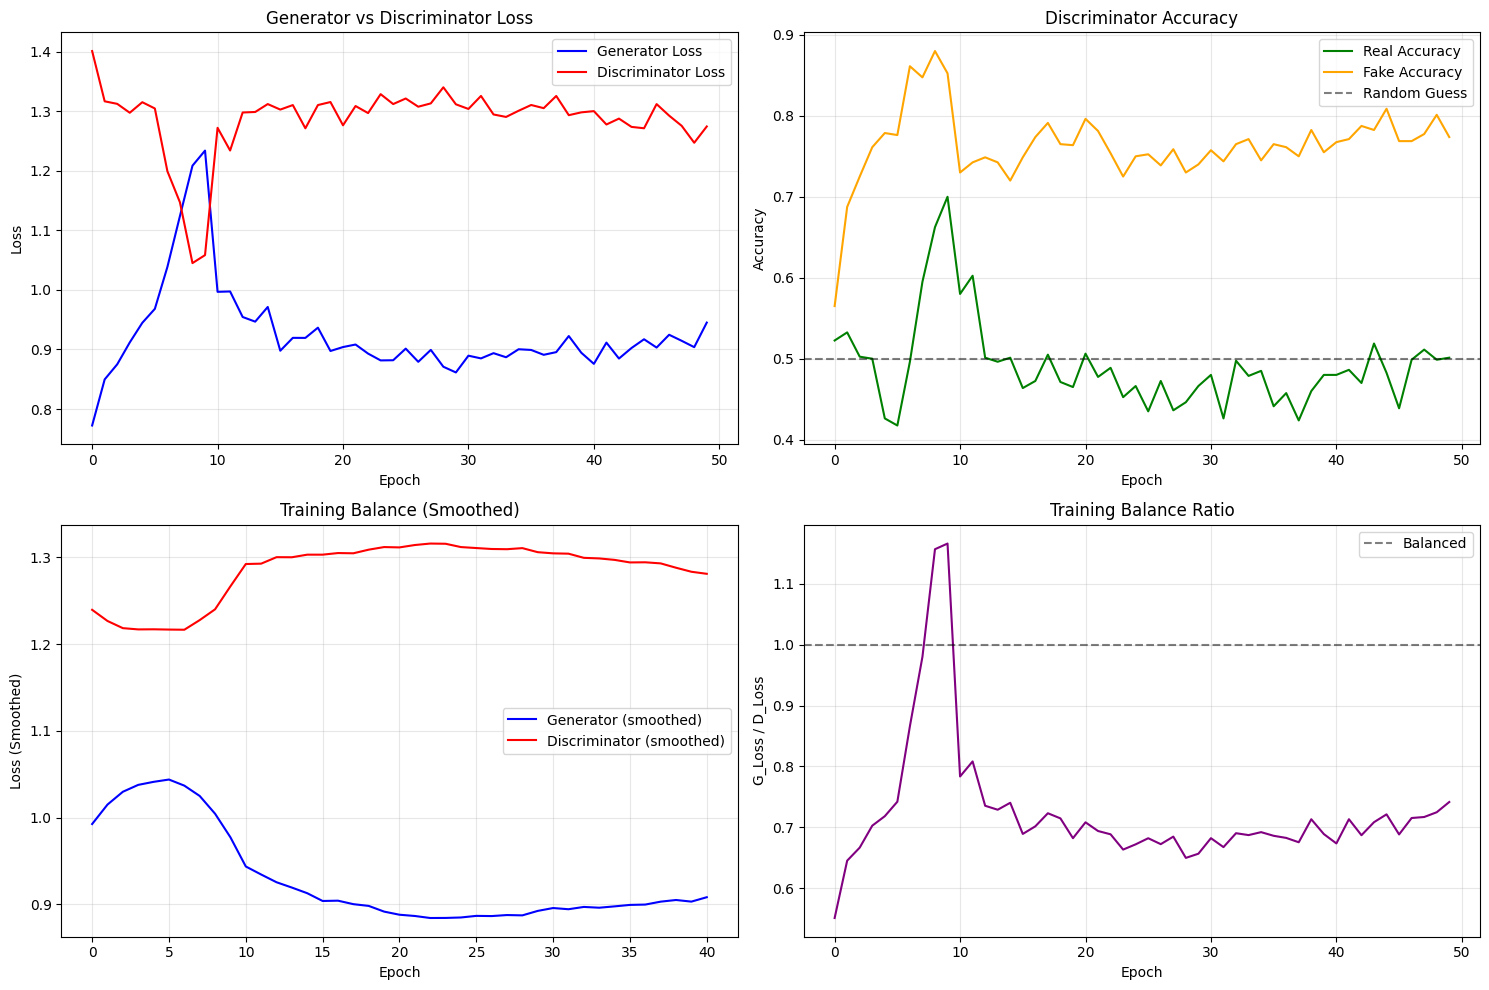


🎨 Testing generation with real conditions...


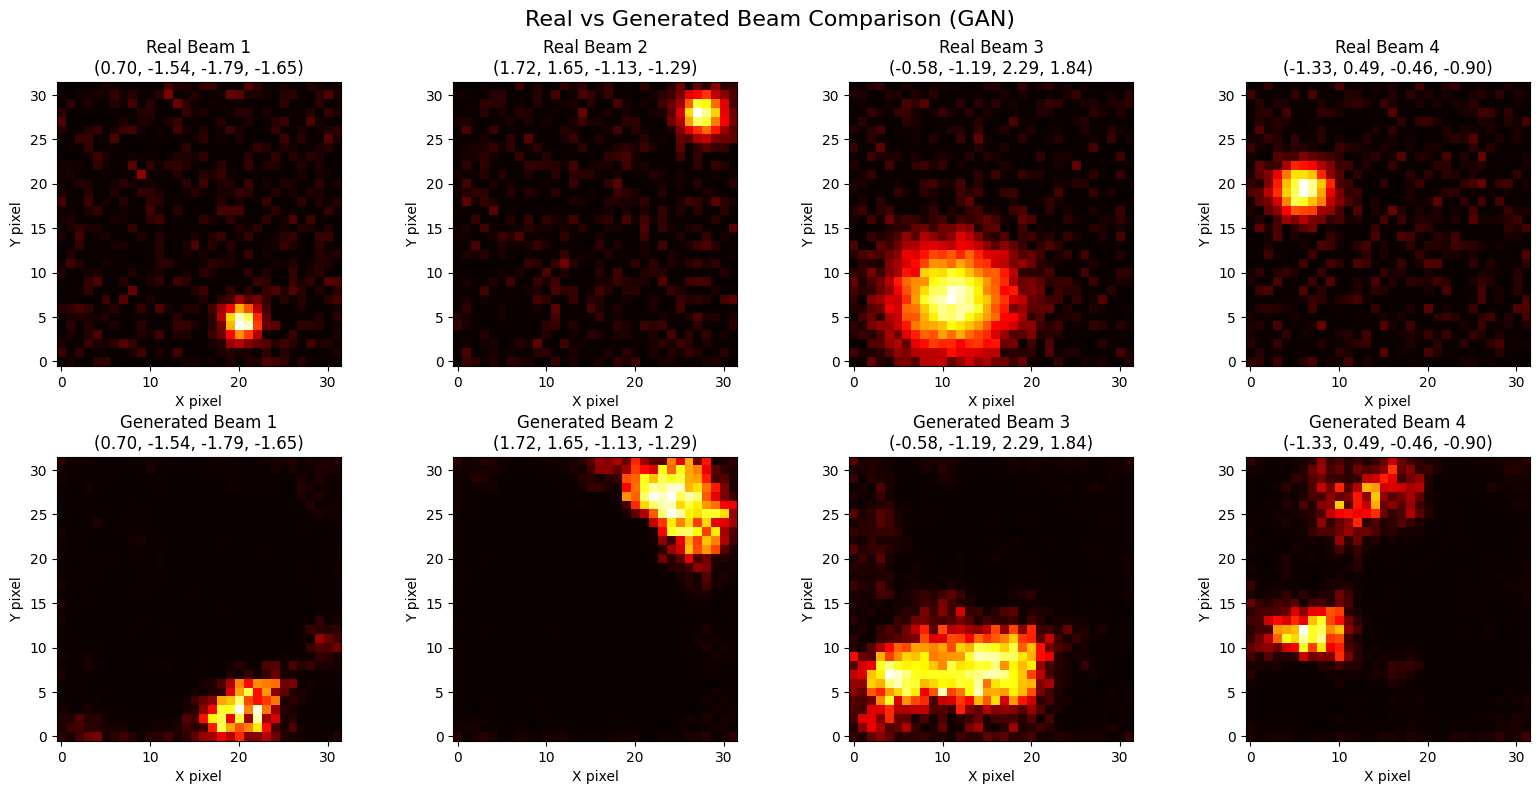

1. Varying X position (left to right)...


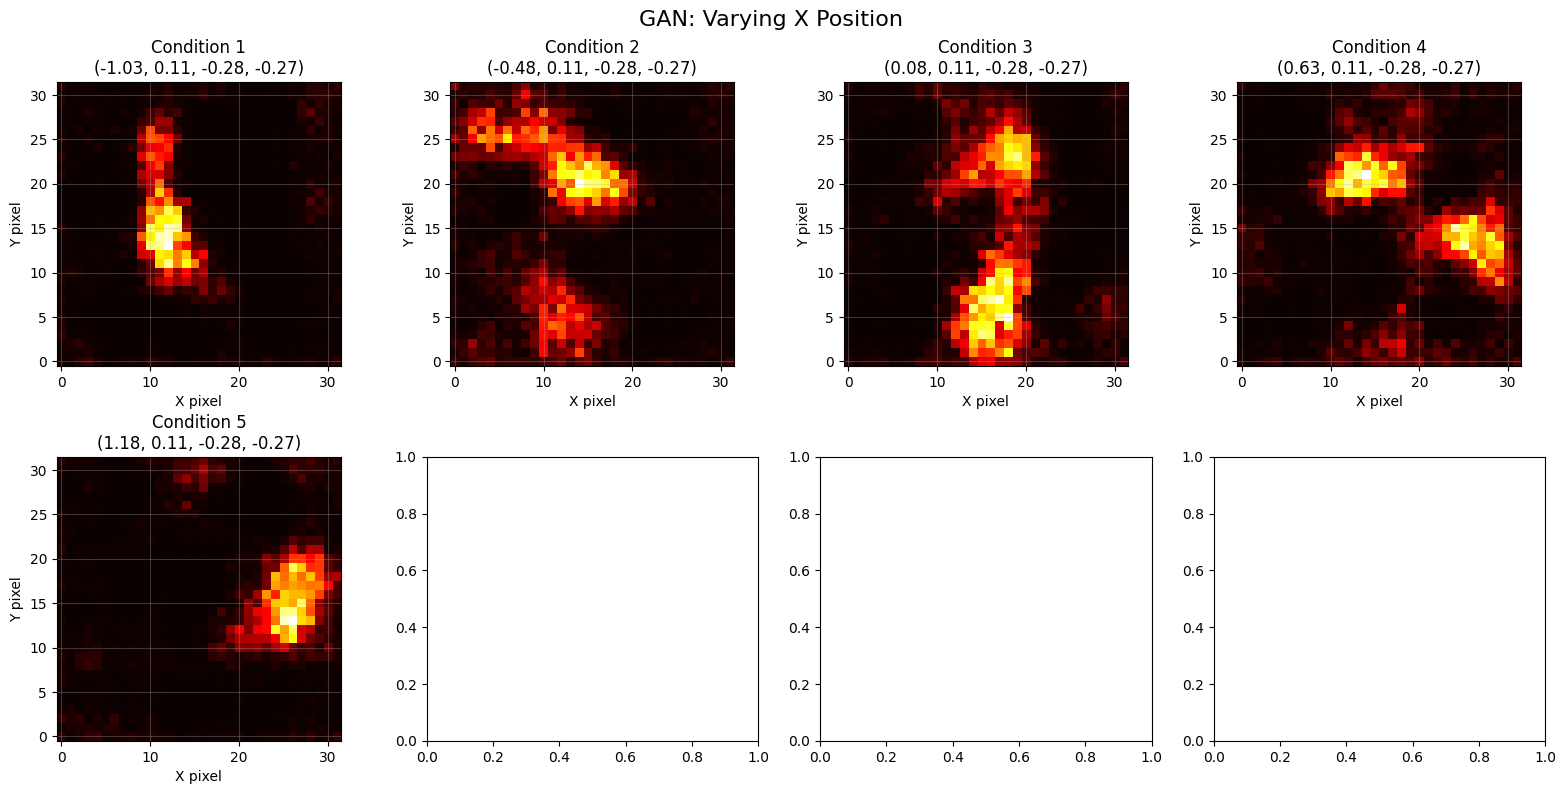

2. Varying Y position (bottom to top)...


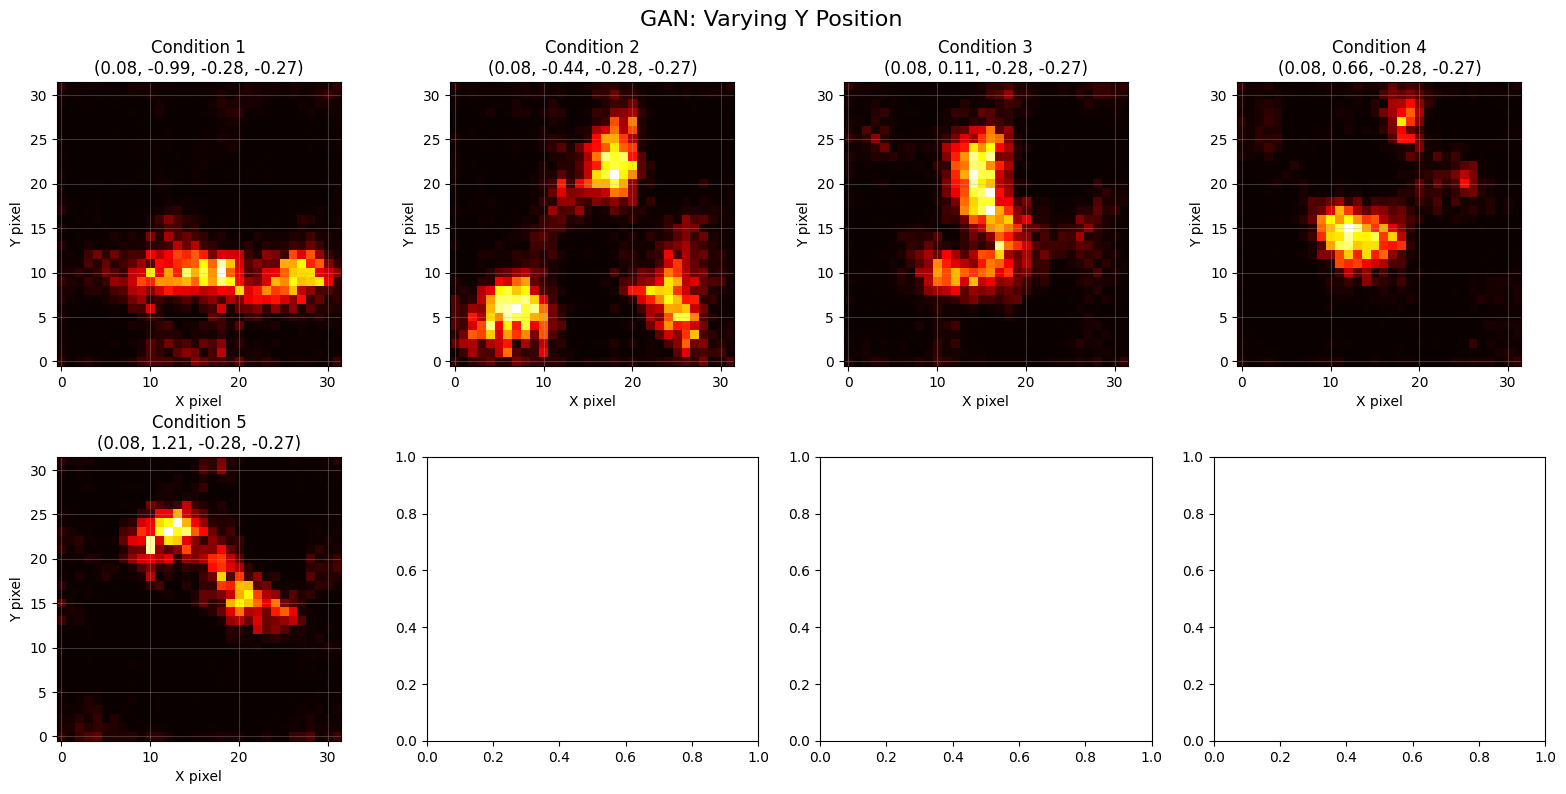

3. Varying beam size (small to large)...


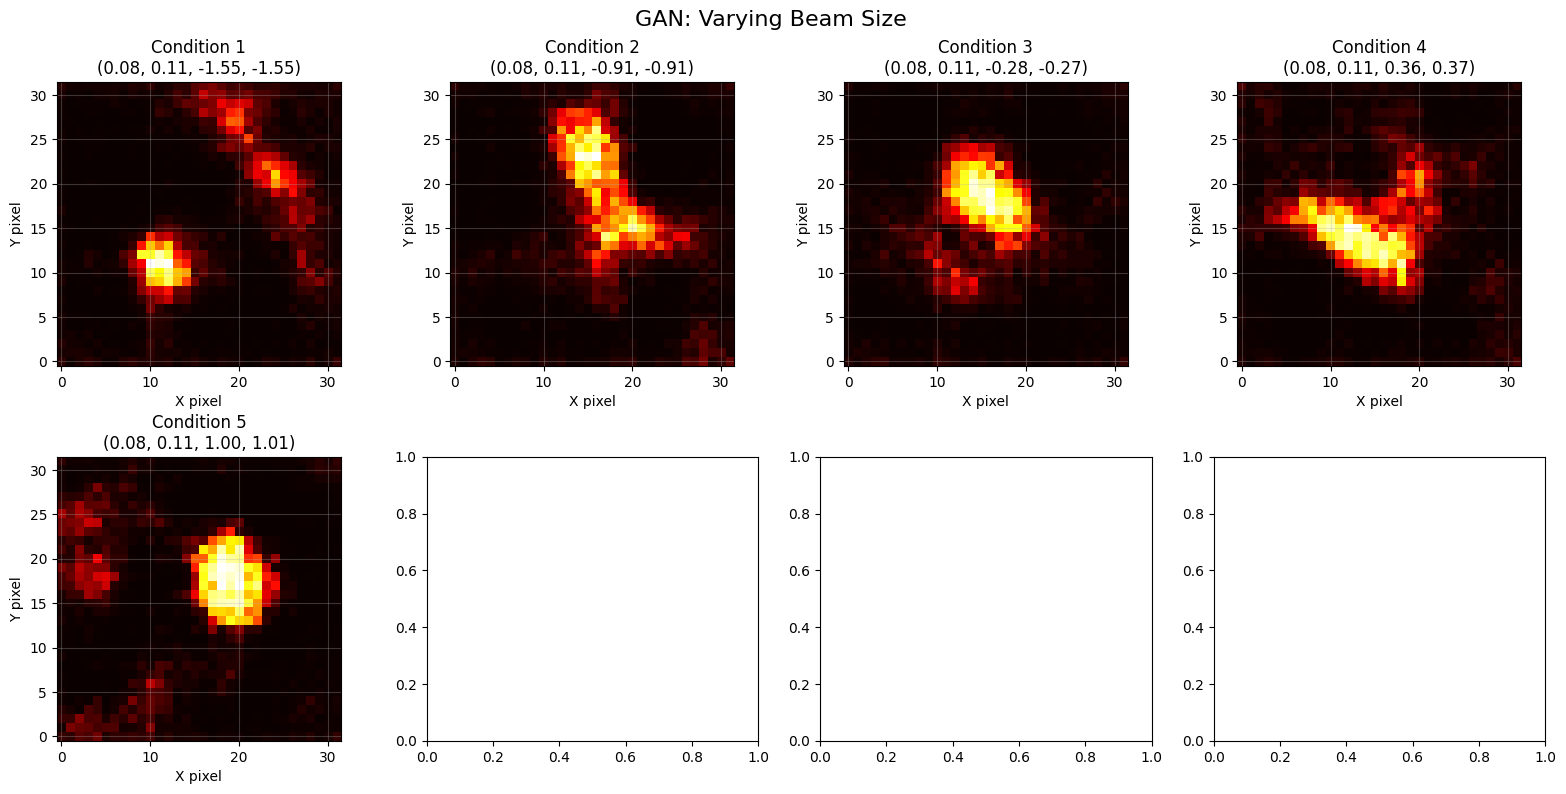

4. Custom beam patterns...


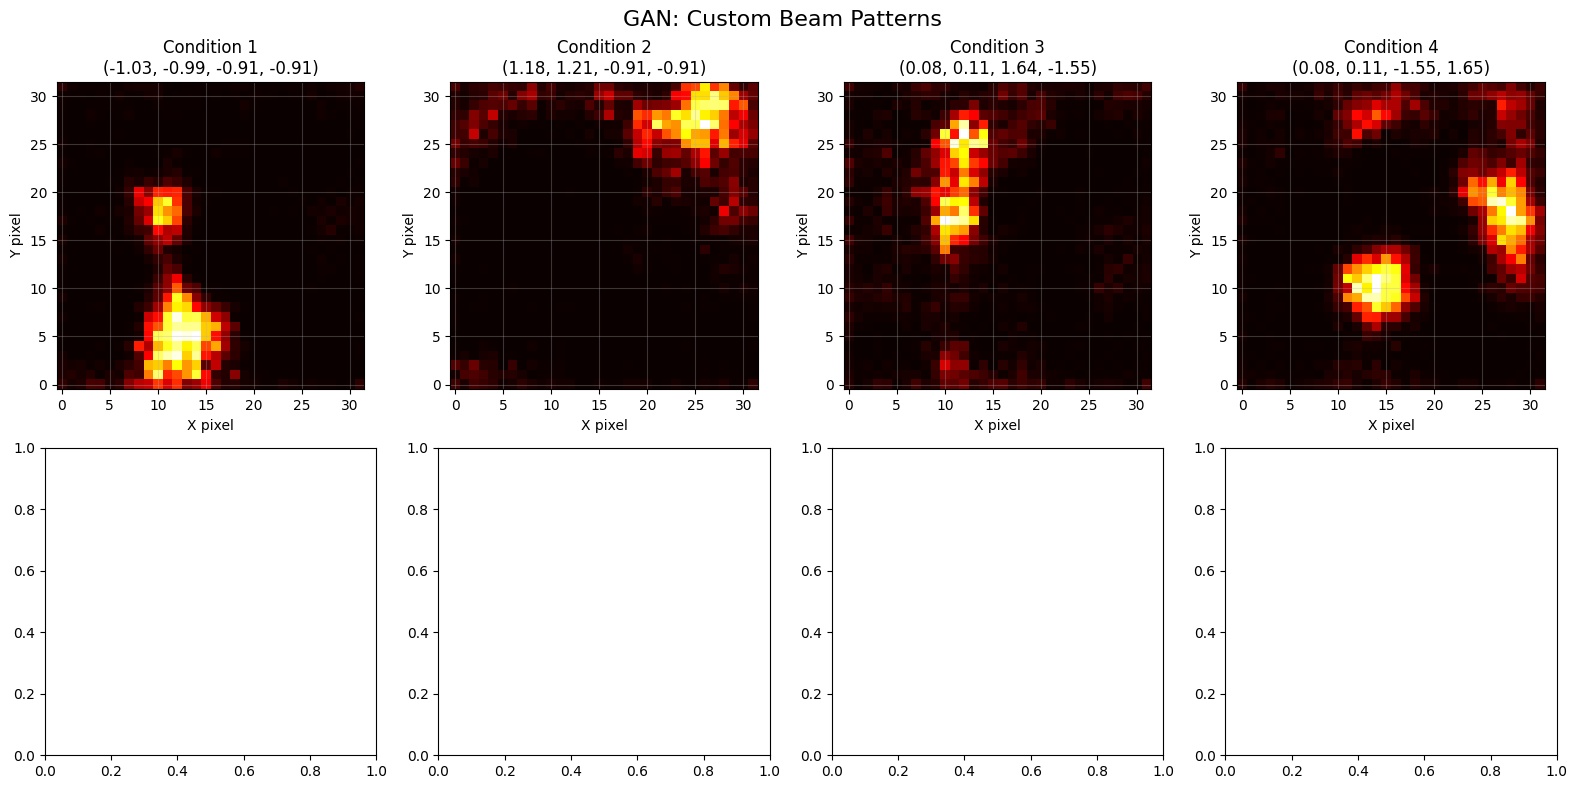


Try these ideas:
1. Extreme positions: Beams at the very edges
2. Tiny beams: Very small sigma values
3. Giant beams: Large sigma values that fill most of the image
4. Aspect ratios: Very wide or very tall beams

\CUSTOM BEAM GENERATION - Modify these parameters
Generating beams with your custom parameters...
Positions: [(4, 4), (28, 28), (16, 4), (16, 28)]
Sizes: [(1.0, 1.0), (5.0, 1.0), (3.0, 1.0), (2.0, 5.0)]


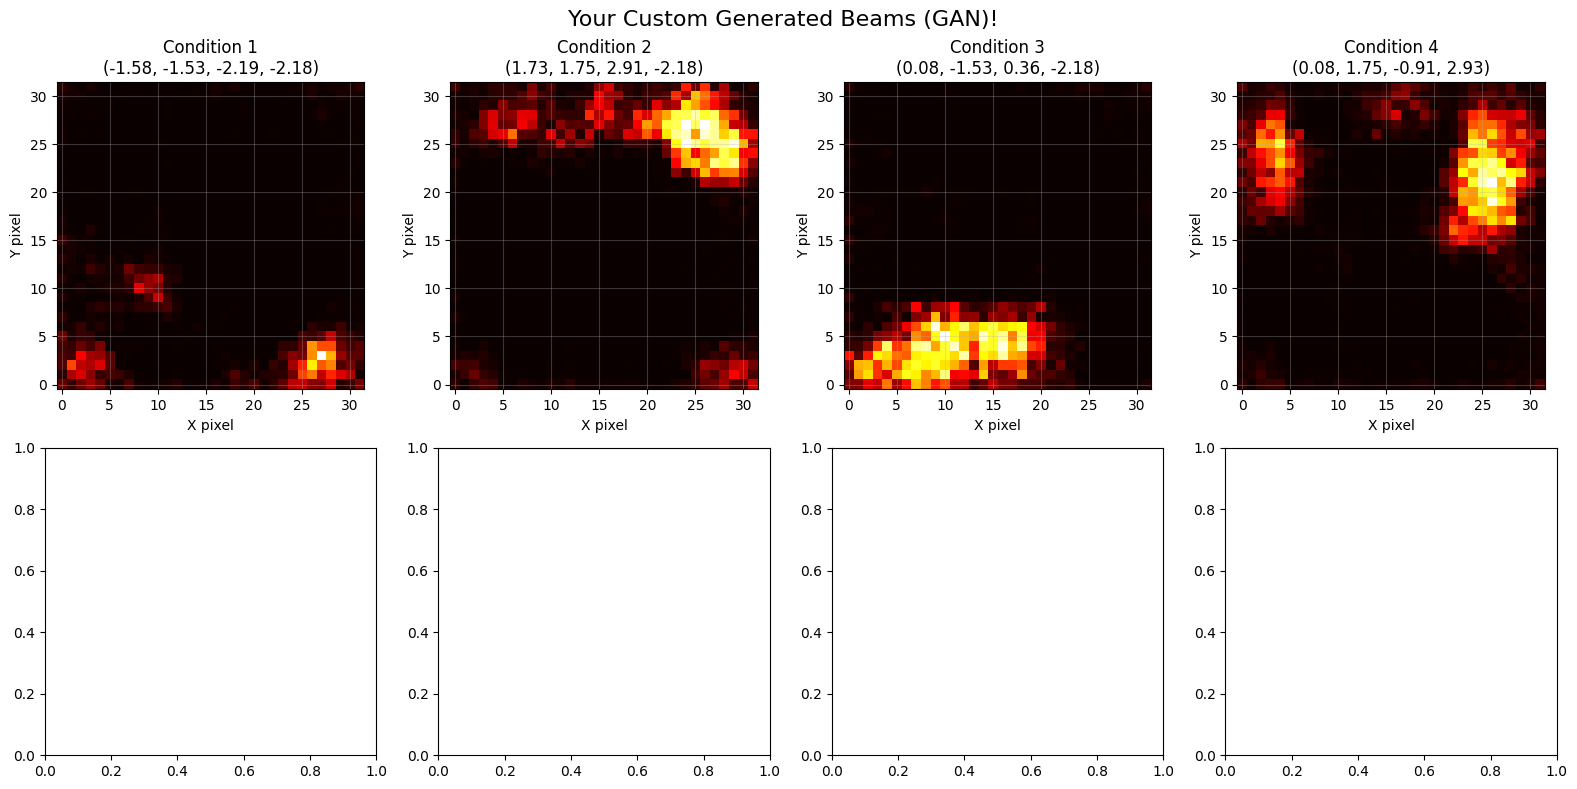

In [10]:
print("🚀 Running GAN experiment...")
latent_dim = 16
gan_results = run_gan_experiment(
    latent_dim=latent_dim,            
    base_channels=8,          
    lr_g=0.0002,              
    lr_d=0.0002,              
    batch_size=32,            
    num_epochs=50            
)

print("""
Try these ideas:
1. Extreme positions: Beams at the very edges
2. Tiny beams: Very small sigma values
3. Giant beams: Large sigma values that fill most of the image
4. Aspect ratios: Very wide or very tall beams
""")

# Interactive custom generation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = gan_results['generator']
train_dataset = gan_results['train_dataset']

print("\CUSTOM BEAM GENERATION - Modify these parameters")

custom_x_centers = [4, 28, 16, 16]        # X positions
custom_y_centers = [4, 28, 4, 28]         # Y positions  
custom_sigma_xs = [1.0, 5.0, 3.0, 2.0]    # X beam widths
custom_sigma_ys = [1.0, 1.0, 1.0, 5.0]    # Y beam widths

print(f"Generating beams with your custom parameters...")
print(f"Positions: {list(zip(custom_x_centers, custom_y_centers))}")
print(f"Sizes: {list(zip(custom_sigma_xs, custom_sigma_ys))}")

custom_conditions = create_custom_conditions_gan(
    custom_x_centers, custom_y_centers, 
    custom_sigma_xs, custom_sigma_ys,
    train_dataset
)

custom_generated = generate_images(generator, custom_conditions, latent_dim, device)
visualize_generated_beams_gan(custom_generated, custom_conditions, "Your Custom Generated Beams (GAN)!")
